In [ ]:
from pathlib import Path
import os

DAY = "20251201"
Version = "v1"

PROJECT_ROOT = Path(os.getenv("LLMSC_ROOT", ".")).resolve()

DATA_DIR = Path(os.getenv("LLMSC_DATA_DIR", PROJECT_ROOT / "input")).resolve()
OUT_DIR  = Path(os.getenv("LLMSC_OUT_DIR",  PROJECT_ROOT / "runs" / f"{DAY}.{Version}")).resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
RANDOM_SEED = 42
import random, os
import numpy as np
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")


🔒 Random seed set to 42 for reproducibility.


In [ ]:
import os
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "")
USE_LLM = bool(GEMINI_API_KEY)

if not USE_LLM:
    print("⚠️ GEMINI_API_KEY not set → LLM inference cells will be skipped.")

In [ ]:
import google.generativeai as genai
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy import sparse
from scipy import io
import adjustText
from adjustText import adjust_text
import gc
import re
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import userdata

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s:%(name)s:%(message)s"
)

import llm_sc_curator
from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ==========================================
# 1. API
# ==========================================

genai.configure(api_key=GEMINI_API_KEY)
print("--- Available Models for your Key ---")
try:
    for m in genai.list_models():
        if 'generateContent' in m.supported_generation_methods:
            print(m.name)
except Exception as e:
    print(f"Error: {e}")

--- Available Models for your Key ---
models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image-preview
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-pro-image-preview
models/nano-banana-pro-preview
models/gemini-robotics-er-1.5-preview
models/gemini-2.5-computer-

In [ ]:
MODEL_NAME = 'models/gemini-2.5-pro'

# MODEL_NAME = 'models/gemini-3-pro-preview'
# MODEL_NAME = 'models/gemini-2.5-flash'
# MODEL_NAME = 'models/gemini-2.0-flash'

print(f"Using Model: {MODEL_NAME}")
model = genai.GenerativeModel(MODEL_NAME)

Using Model: models/gemini-2.5-pro


In [ ]:
save_path = OUT_DIR / "cd8_benchmark_data.h5ad"

print(f"\n Loading data...: {save_path}")
adata= sc.read_h5ad(save_path)
print("\nCell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):")
print(adata.obs['meta.cluster'].value_counts().head(10))


 Loading data...: /runs/20251201.v1/cd8_benchmark_data.h5ad

Cell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):
meta.cluster
CD8.c01.Tn.MAL          300
CD8.c02.Tm.IL7R         300
CD8.c03.Tm.RPS12        300
CD8.c04.Tm.CD52         300
CD8.c05.Tem.CXCR5       300
CD8.c06.Tem.GZMK        300
CD8.c07.Temra.CX3CR1    300
CD8.c11.Tex.PDCD1       300
CD8.c10.Trm.ZNF683      300
CD8.c12.Tex.CXCL13      300
Name: count, dtype: int64


In [ ]:
adata.obs

,cancerType,patient,libraryID,loc,meta.cluster,platform,Cancer_Type,Sample_ID
TTGAACGCACGGATAG.13,ESCA,ESCA.P20181123,ESCA-P20181123-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,TTGAACGCACGGATAG.13
CCTAGCTGTTTCCACC.7,ESCA,ESCA.P20190410,ESCA-P20190410-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,CCTAGCTGTTTCCACC.7
TGATTTCCACCCTATC.5,ESCA,ESCA.P20190404,ESCA-P20190404-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,TGATTTCCACCCTATC.5
GGAGCAACAATCTACG.7,ESCA,ESCA.P20190410,ESCA-P20190410-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,GGAGCAACAATCTACG.7
GCACATAAGGAACTGC.10,ESCA,ESCA.P20190411,ESCA-P20190411-T,T,CD8.c07.Temra.CX3CR1,10X,ESCA,GCACATAAGGAACTGC.10
...,...,...,...,...,...,...,...,...
GTCACGGGTGGTAACG.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,GTCACGGGTGGTAACG.51
TCAGCTCTCTATCCCG.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,TCAGCTCTCTATCCCG.51
TGATTTCAGTATTGGA.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,TGATTTCAGTATTGGA.51
TTGCCGTCAGCCTATA.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,TTGCCGTCAGCCTATA.51


In [ ]:
# ==========================================
# Correct Label Generation Function
# Definition based on cluster IDs from Zheng et al. 2021
# ==========================================

def get_cd8_ground_truth(cluster_name: str) -> str:
    """
    Map Zheng et al. CD8 meta.cluster names to GT categories.

    The GT labels are intentionally slightly finer (Naive / Effector / EffectorMemory /
    Exhausted / ISG / MAIT / NK_killer / Cycling), and are later collapsed into
    coarse (major, state) pairs by CD8_HIER_CFG.gt_rules.
    """
    s = str(cluster_name).lower()

    # 1) Distinct functional states
    if "mait" in s:
        return "CD8_MAIT"

    if any(k in s for k in ["isg", "interferon", "ifit1"]):
        return "CD8_ISG"

    if any(k in s for k in ["proliferating", "cycle", "mki67", "top2a"]):
        return "CD8_Cycling"

    # 2) NK-like killer pool (exclude explicit T cell labels)
    if "nk" in s and "t cell" not in s:
        return "CD8_NK_Killer"

    # 3) Exhausted pool
    if any(k in s for k in ["tex", "exhausted", "pdcd1"]):
        return "CD8_Exhausted"

    # 4) TRM / resident memory → treated as EffectorMemory in GT
    if any(k in s for k in ["trm", "resident", "znf683", "itgae", "cd69"]):
        return "CD8_EffectorMemory"

    # 5) Naive pool (true naive; use 'tn.' to avoid Tn/Tm confusion)
    if "tn." in s or "naive" in s:
        return "CD8_Naive"

    # 6) Temra / CX3CR1-high killers
    if any(k in s for k in ["temra", "cx3cr1", "klrg1"]):
        return "CD8_Effector"

    # 7) Tem / Tm / GZMK+ effector-memory clusters
    if any(k in s for k in ["tem.", "tm.", "memory", "gzmk", "aqp3", "ltb"]):
        return "CD8_EffectorMemory"

    # 8) Tk / killer T clusters (Zheng's Tk)
    if "tk" in s or "killer" in s:
        return "CD8_Effector"

    # 9) Fallback
    return "CD8_Other"



print("Applying Ground Truth Mapping...")
adata.obs['GT_Category'] = adata.obs['meta.cluster'].apply(get_cd8_ground_truth)
print(adata.obs['GT_Category'].value_counts())


Applying Ground Truth Mapping...
GT_Category
CD8_EffectorMemory    1983
CD8_Exhausted          928
CD8_Effector           753
CD8_Naive              300
CD8_MAIT               300
CD8_ISG                202
Name: count, dtype: int64


In [ ]:
GT_KEYWORDS_CD8 = {
    "CD8_Exhausted":      ["PDCD1", "HAVCR2", "LAG3", "TOX"],
    "CD8_ISG":            ["ISG15", "IFIT1", "MX1", "STAT1"],
    "CD8_EffectorMemory": ["GZMK", "LTB", "AQP3"],
    "CD8_Effector":       ["GZMB", "PRF1", "GNLY", "CX3CR1", "KLRG1"],
    "CD8_MAIT":           ["SLC4A10", "KLRB1"],
    "CD8_Naive":          ["TCF7", "LEF1", "CCR7", "SELL"],
    "CD8_Cycling":        ["MKI67", "TOP2A"],
}


var_names = adata.var_names
filtered_markers = {k: [g for g in v if g in var_names] for k, v in GT_KEYWORDS_CD8.items()}


In [ ]:
if "highly_variable" not in adata.var.columns:
    print("[Setup] Computing global HVGs for CD8 benchmark...")

    hvg_kwargs = dict(
        n_top_genes=2000,
        subset=False,
        batch_key="Cancer_Type",
    )

    if "counts" in adata.layers:
        hvg_kwargs.update(
            flavor="seurat_v3",
            layer="counts",
        )
        print("[HVG] Using flavor='seurat_v3' on layers['counts'] with batch_key='Cancer_Type'.")
    else:
        hvg_kwargs.update(
            flavor="seurat",
        )
        print("[HVG] `layers['counts']` not found → using flavor='seurat' on log1p .X.")

    print(hvg_kwargs)

    sc.pp.highly_variable_genes(adata, **hvg_kwargs)

# Curator Initialize
curator = LLMscCurator(api_key=GEMINI_API_KEY, model_name=MODEL_NAME)
curator.set_global_context(adata)

[Setup] Computing global HVGs for CD8 benchmark...
[HVG] Using flavor='seurat_v3' on layers['counts'] with batch_key='Cancer_Type'.
{'n_top_genes': 2000, 'subset': False, 'batch_key': 'Cancer_Type', 'flavor': 'seurat_v3', 'layer': 'counts'}


In [ ]:
import sys
REPO_ROOT = os.path.join(indir, "LLM-scCurator")
sys.path.append(REPO_ROOT)

from benchmarks.hierarchical_scoring import _parse_state_generic
from benchmarks.cd8_config import CD8_HIER_CFG
from benchmarks.cd4_config import CD4_HIER_CFG
from benchmarks.mouse_b_config import MOUSE_B_CFG

from llm_sc_curator.masking import FeatureDistiller
from llm_sc_curator.noise_lists import NOISE_PATTERNS, NOISE_LISTS, CELL_CYCLE_GENES

from benchmarks.cd8_config import CD8_HIER_CFG
from benchmarks.hierarchical_scoring import score_hierarchical
from benchmarks.gt_mappings import get_cd8_ground_truth


In [ ]:
# ------------------------------------------
# 0. Settings
# ------------------------------------------
EXCLUDE_GT_LABELS = {"CD8_Other", "Other", "Unknown"}

FOCUS_GT_LABELS = [
    "CD8_Naive",
    "CD8_EffectorMemory",
    "CD8_Exhausted",
    "CD8_Effector",
    "CD8_MAIT",
    "CD8_ISG"
]

MAX_CLUSTERS_PER_GT = 1

In [ ]:
# ------------------------------------------
# 1. Organizing Cluster Information
# ------------------------------------------
unique_clusters = sorted(adata.obs["meta.cluster"].unique())

cluster_meta_all = []     # [(cluster_name, gt_label), ...]
dropped_clusters = []     # Excluded clusters

for c in unique_clusters:
    gt_label = get_cd8_ground_truth(c)
    if gt_label in EXCLUDE_GT_LABELS or gt_label is None:
        dropped_clusters.append((c, gt_label))
        continue
    cluster_meta_all.append((c, gt_label))

print("🚀 Preparing CD8 robustness benchmark...")
print(f"   All clusters in adata: {len(unique_clusters)}")
print(f"   Included clusters     : {len(cluster_meta_all)}")
if dropped_clusters:
    print("   ⚠️ Excluded ambiguous clusters:")
    for c, lab in dropped_clusters:
        print(f"      - {c} (GT={lab})")


🚀 Preparing CD8 robustness benchmark...
   All clusters in adata: 17
   Included clusters     : 17


In [ ]:
# ------------------------------------------
# 2. Select a subset of representative clusters
#    (Use all clusters if FOCUS_GT_LABELS is empty)
# ------------------------------------------
selected = []
gt_counts = {}

for c, gt in cluster_meta_all:
    if FOCUS_GT_LABELS and gt not in FOCUS_GT_LABELS:
        continue
    if gt_counts.get(gt, 0) >= MAX_CLUSTERS_PER_GT:
        continue
    selected.append((c, gt))
    gt_counts[gt] = gt_counts.get(gt, 0) + 1

if selected:
    cluster_meta = selected
    print("\n📌 Using a focused subset of clusters for robustness test:")
    for c, gt in cluster_meta:
        print(f"   - {c} (GT={gt})")
else:
    cluster_meta = cluster_meta_all
    print("\n📌 Fallback: Using all eligible clusters for robustness test.")



📌 Using a focused subset of clusters for robustness test:
   - CD8.c01.Tn.MAL (GT=CD8_Naive)
   - CD8.c02.Tm.IL7R (GT=CD8_EffectorMemory)
   - CD8.c07.Temra.CX3CR1 (GT=CD8_Effector)
   - CD8.c11.Tex.PDCD1 (GT=CD8_Exhausted)
   - CD8.c15.ISG.IFIT1 (GT=CD8_ISG)
   - CD8.c16.MAIT.SLC4A10 (GT=CD8_MAIT)


In [ ]:
# ------------------------------------------
# 3. Calculate the DE rank for each cluster only once
#    (binary_group = Target vs Rest)
# ------------------------------------------
RANK_CACHE = {}  # cluster_name -> list of genes (All Ranks)

print("\n📊 Computing DE ranks per cluster (Target vs Rest)...")

for i, (cluster_name, gt_label) in enumerate(cluster_meta):
    print(f"   [{i+1}/{len(cluster_meta)}] {cluster_name} → GT={gt_label}")

    # Target Cluster vs. Others Binarization
    adata.obs["binary_group"] = "Rest"
    adata.obs.loc[adata.obs["meta.cluster"] == cluster_name, "binary_group"] = "Target"

    try:
        sc.tl.rank_genes_groups(
            adata,
            groupby="binary_group",
            groups=["Target"],
            reference="Rest",
            method="wilcoxon",
            use_raw=False,
        )
        df_rank = sc.get.rank_genes_groups_df(adata, group="Target")
        gene_rank_list = df_rank["names"].tolist()
        RANK_CACHE[cluster_name] = gene_rank_list
    except Exception as e:
        print(f"   [WARN] rank_genes_groups failed for {cluster_name}: {e}")
        RANK_CACHE[cluster_name] = []

print("\n✅ DE ranking cache complete.")



📊 Computing DE ranks per cluster (Target vs Rest)...
   [1/6] CD8.c01.Tn.MAL → GT=CD8_Naive
   [2/6] CD8.c02.Tm.IL7R → GT=CD8_EffectorMemory
   [3/6] CD8.c07.Temra.CX3CR1 → GT=CD8_Effector
   [4/6] CD8.c11.Tex.PDCD1 → GT=CD8_Exhausted
   [5/6] CD8.c15.ISG.IFIT1 → GT=CD8_ISG
   [6/6] CD8.c16.MAIT.SLC4A10 → GT=CD8_MAIT

✅ DE ranking cache complete.


In [ ]:
def eval_cd8_prediction_from_result(result, gt_label: str) -> float:
    """
    Based on the result of curator.annotate (dict or str) and the GT label,
    returns a score in the range [0,1] using hierarchical_scoring.
    """
    if isinstance(result, dict):
        cell_type = str(result.get("cell_type", ""))
        reasoning = str(result.get("reasoning", ""))
        text = (cell_type + " " + reasoning).strip()
    else:
        text = str(result).strip()

    row = pd.Series(
        {
            "Ground_Truth": gt_label,
            "LLM_Pred": text,
        }
    )

    score = score_hierarchical(row, "LLM_Pred", cfg=CD8_HIER_CFG)
    return float(score)


In [ ]:
# ------------------------------------------
# 4. Main Loop: Standard vs Curator for each N_Genes
# ------------------------------------------
N_GENES_LIST = [10, 20, 50, 100, 200]

# Rate limit (seconds)
SLEEP_STD = 2.0
SLEEP_CUR = 2.0

print("\n🚀 Starting Robustness Benchmark (Generates cd8_robustness_results_final.csv)...")
print(f"   N Levels: {N_GENES_LIST}")
print(f"   #Clusters: {len(cluster_meta)}")

robustness_data = []

for n_genes in N_GENES_LIST:
    print(f"\n--- Testing Input Size: Top {n_genes} Genes ---")

    for cluster_name, gt_label in cluster_meta:
        gene_rank = RANK_CACHE.get(cluster_name, [])
        genes_std = gene_rank[:n_genes] if gene_rank else []

        print(f"   ▶ Cluster: {cluster_name} (GT={gt_label}), N={n_genes}")

        # ============================
        # A. Standard Workflow
        # ============================
        try:
            if genes_std:
                print("      [Std] Calling curator.annotate(...)")
                res_std = curator.annotate(
                    genes_std,
                    use_auto_context=False
                )
                print("      [Std] annotate() returned.")
            else:
                res_std = {
                    "cell_type": "NoGenes",
                    "confidence": "Low",
                    "reasoning": "Empty DEG list",
                }
                print("      [Std] No genes available → returning 'NoGenes'.")

            score_std = eval_cd8_prediction_from_result(res_std, gt_label)
            print(f"      [Std] Score = {score_std:.2f}")
        except Exception as e:
            print(f"⚠️ Error Std ({cluster_name}, N={n_genes}): {e}")
            res_std = {
                "cell_type": "Error",
                "confidence": "Low",
                "reasoning": str(e),
            }
            score_std = 0.0

        time.sleep(SLEEP_STD)  # API Rate Limit

        # ============================
        # B. LLM-scCurator (Proposed)
        # ============================
        try:
            print("      [Cur] Calling curator.curate_features(...)")
            genes_cur = curator.curate_features(
                adata,
                group_col="meta.cluster",
                target_group=cluster_name,
                n_top=n_genes,
                use_statistics=True,  # Gini + Regex Masking
            )
            print(f"      [Cur] curate_features() returned {len(genes_cur)} genes.")
        except Exception as e:
            print(f"⚠️ curate_features failed ({cluster_name}, N={n_genes}): {e}")
            genes_cur = []

        try:
            if genes_cur:
                print("      [Cur] Calling curator.annotate(...)")
                res_cur = curator.annotate(
                    genes_cur
                )
                print("      [Cur] annotate() returned.")
            else:
                res_cur = {
                    "cell_type": "NoGenes",
                    "confidence": "Low",
                    "reasoning": "Curated list empty",
                }
                print("      [Cur] No curated genes → 'NoGenes'.")

            score_cur = eval_cd8_prediction_from_result(res_cur, gt_label)
            print(f"      [Cur] Score = {score_cur:.2f}")
        except Exception as e:
            print(f"⚠️ Error Cur ({cluster_name}, N={n_genes}): {e}")
            res_cur = {
                "cell_type": "Error",
                "confidence": "Low",
                "reasoning": str(e),
            }
            score_cur = 0.0

        # ============================
        # C. Results Record
        # ============================
        robustness_data.append(
            {
                "Cluster_ID": cluster_name,
                "Ground_Truth": gt_label,
                "N_Genes": int(n_genes),

                "Std_Score": float(score_std),
                "Std_Answer": res_std.get("cell_type", str(res_std)),

                "Cur_Score": float(score_cur),
                "Cur_Answer": res_cur.get("cell_type", str(res_cur)),

                "Score_Diff": float(score_cur - score_std),
            }
        )

        print(f"   ✅ [{cluster_name}] N={n_genes}: Std={score_std:.2f} → Cur={score_cur:.2f}")
        time.sleep(SLEEP_CUR)

    tmp_path = f"{OUT_DIR}/cd8_robustness_intermediate.csv"
    pd.DataFrame(robustness_data).to_csv(tmp_path, index=False)
    print(f"   💾 Intermediate results saved to {tmp_path}")

df_final = pd.DataFrame(robustness_data)
csv_path = f"{OUT_DIR}/cd8_robustness_results_final.csv"
df_final.to_csv(csv_path, index=False)

print(f"\n✅ Robustness benchmark complete. Data saved to: {csv_path}")



🚀 Starting Robustness Benchmark (Generates cd8_robustness_results_final.csv)...
   N Levels: [10, 20, 50, 100, 200]
   #Clusters: 6

--- Testing Input Size: Top 10 Genes ---
   ▶ Cluster: CD8.c01.Tn.MAL (GT=CD8_Naive), N=10
      [Std] Calling curator.annotate(...)
      [Std] annotate() returned.
      [Std] Score = 0.70
      [Cur] Calling curator.curate_features(...)
      [Cur] curate_features() returned 10 genes.
      [Cur] Calling curator.annotate(...)
      [Cur] annotate() returned.
      [Cur] Score = 1.00
   ✅ [CD8.c01.Tn.MAL] N=10: Std=0.70 → Cur=1.00
   ▶ Cluster: CD8.c02.Tm.IL7R (GT=CD8_EffectorMemory), N=10
      [Std] Calling curator.annotate(...)
      [Std] annotate() returned.
      [Std] Score = 0.70
      [Cur] Calling curator.curate_features(...)
      [Cur] curate_features() returned 10 genes.
      [Cur] Calling curator.annotate(...)
      [Cur] annotate() returned.
      [Cur] Score = 0.70
   ✅ [CD8.c02.Tm.IL7R] N=10: Std=0.70 → Cur=0.70
   ▶ Cluster: CD8.c07.

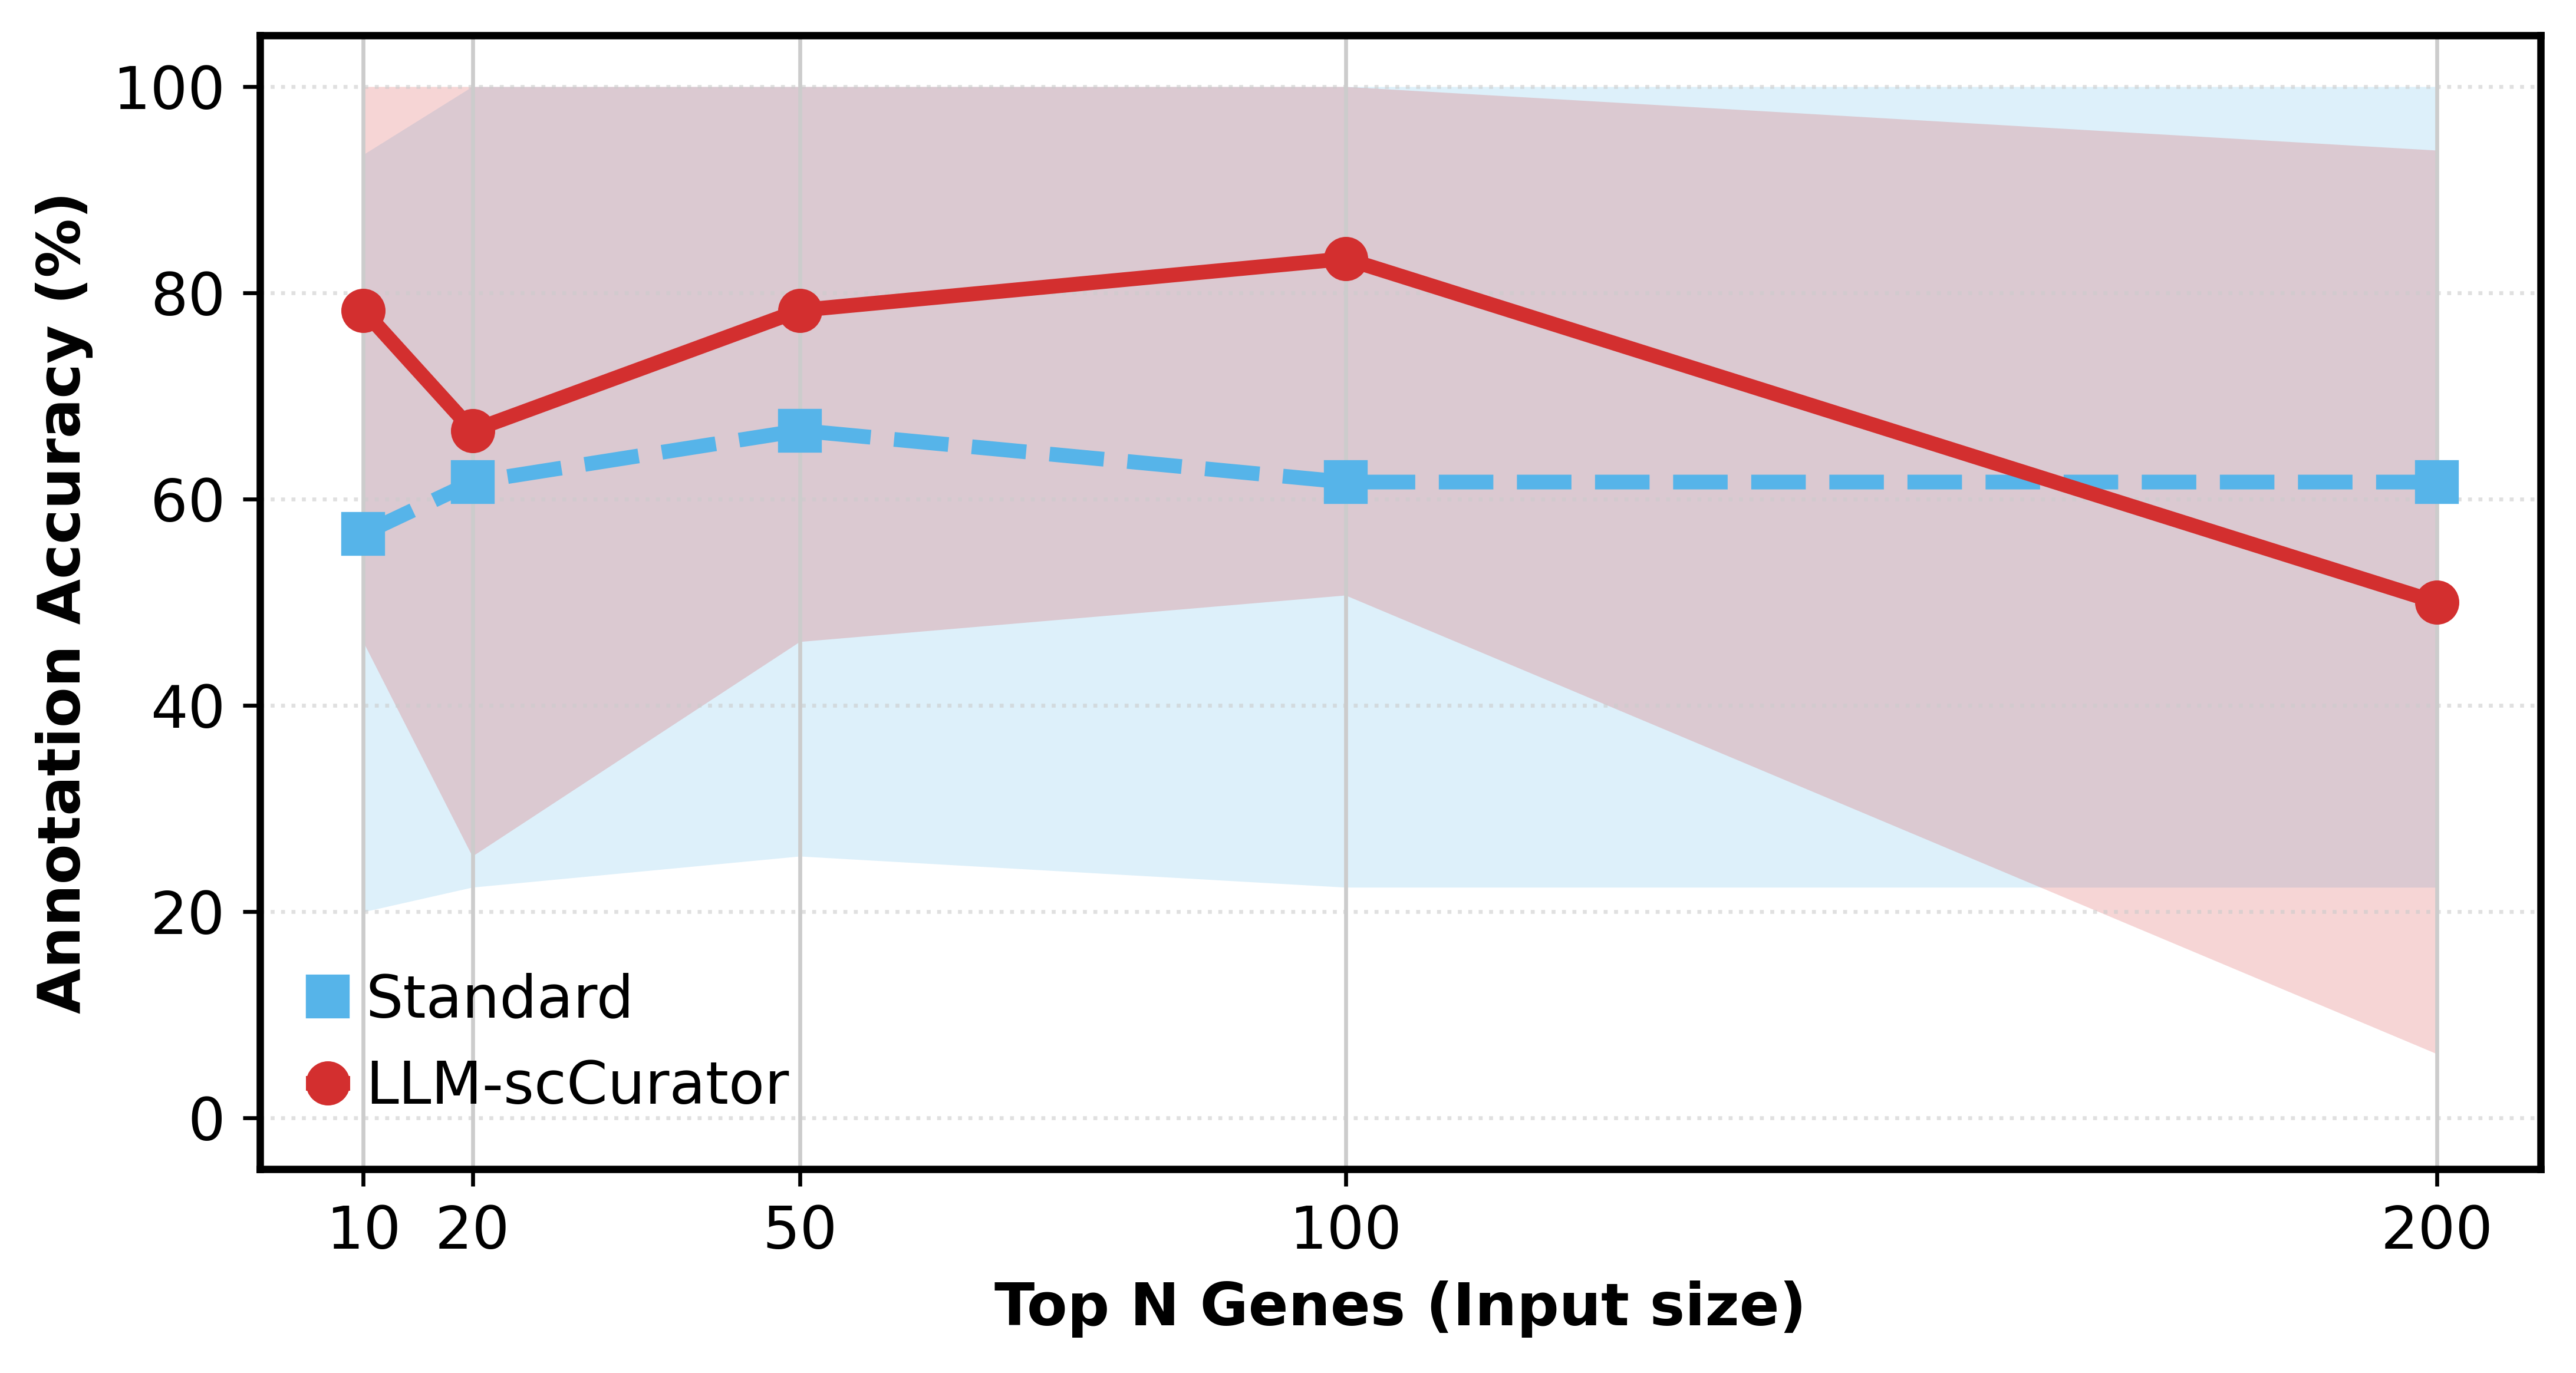

✅ Figure generated: /runs/20251201.v1/fig2b_accuracy_withCIband_pct.png


In [ ]:
csv_path = f"{OUT_DIR}/cd8_robustness_results_final.csv"
df = pd.read_csv(csv_path)

# Conversion to Long Format
df_long = pd.melt(
    df,
    id_vars=["Cluster_ID", "N_Genes"],
    value_vars=["Std_Score", "Cur_Score"],
    var_name="Method",
    value_name="Accuracy",
)
df_long["Method"] = df_long["Method"].replace({
    "Std_Score": "Standard",
    "Cur_Score": "LLM-scCurator",
})

# ---- Calculate mean / 95% CI for each Method × N_Genes ----
summary = (
    df_long
    .groupby(["Method", "N_Genes"], as_index=False)
    .agg(
        mean_acc=("Accuracy", "mean"),
        std_acc=("Accuracy", "std"),
        n=("Accuracy", "count"),
    )
)

summary["std_acc"] = summary["std_acc"].fillna(0.0)
summary["se"] = summary["std_acc"] / summary["n"].clip(lower=1).pow(0.5)

z = 1.96  # 95%CI
summary["lower"] = summary["mean_acc"] - z * summary["se"]
summary["upper"] = summary["mean_acc"] + z * summary["se"]

# （Anti-protrusion: Clip at 0–1）
summary["lower"] = summary["lower"].clip(0.0, 1.0)
summary["upper"] = summary["upper"].clip(0.0, 1.0)

# Convert to %（0–1 → 0–100）
summary[["mean_acc", "lower", "upper"]] = summary[["mean_acc", "lower", "upper"]] * 100.0

# ---- Plot Settings ----
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["font.size"] = 14
plt.rcParams["axes.linewidth"] = 1.5

COLORS = {
    "Standard": "#56B4E9",       # Light blue
    "LLM-scCurator": "#D32F2F",  # Red
}
MARKERS = {
    "Standard": "s",
    "LLM-scCurator": "o",
}
LINESTYLES = {
    "Standard": "--",
    "LLM-scCurator": "-",
}

fig, ax = plt.subplots(figsize=(7.5, 4.1), dpi=300)

methods_order = ["Standard", "LLM-scCurator"]

for method in methods_order:
    sub = summary[summary["Method"] == method].sort_values("N_Genes")

    x = sub["N_Genes"].values
    y = sub["mean_acc"].values          # 0–100 (%)
    lower = sub["lower"].values
    upper = sub["upper"].values

    # 95% CI band
    ax.fill_between(
        x,
        lower,
        upper,
        alpha=0.20,
        edgecolor="none",
        facecolor=COLORS[method],
        zorder=1,
    )

    # Average line + marker
    ax.plot(
        x,
        y,
        marker=MARKERS[method],
        linestyle=LINESTYLES[method],
        color=COLORS[method],
        linewidth=3,
        markersize=8,
        label=method,
        zorder=10,
    )

ax.set_xlabel("Top N Genes (Input size)", fontweight="bold", fontsize=12)
ax.set_ylabel("Annotation Accuracy (%)", fontweight="bold", fontsize=12)

ax.set_ylim(-5, 105)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xticks(sorted(df["N_Genes"].unique()))

ax.grid(True, axis="y", linestyle=":", alpha=0.6)

ax.legend(title=None, frameon=False, fontsize=12, loc="best")

plt.tight_layout()
out_path = f"{OUT_DIR}/Fig2c_accuracy_withCIband_pct.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Figure generated: {out_path}")

